### How to verify the execution of a MBQC pattern ?
Let the following circuit.

In [1]:
from graphix.random_objects import rand_circuit, Circuit
import graphix.command
import numpy as np
from graphix.states import BasicStates


nqubits = 2

## This circuit, with |0> states as inputs, yields deterministic outcomes (BQP error p =0)
## (6-nodes pattern)
circuit = Circuit(nqubits)
circuit.cnot(0,1)
circuit.h(0)
circuit.h(1)
states = [BasicStates.ZERO for _ in range(nqubits)]


## This circuit, with |+> states as inputs, yields deterministic outcomes (BQP error p =0)
## (8-nodes pattern)
# circuit = Circuit(nqubits)
# circuit.h(0)
# circuit.h(1)
# circuit.cnot(0,1)
# circuit.h(0)
# circuit.h(1)
# states = [BasicStates.PLUS for _ in range(nqubits)]

pattern = circuit.transpile().pattern
pattern.standardize()

classical_output = pattern.output_nodes
print(classical_output)
# don't forget to add in the output nodes that are not initially measured!
for onode in classical_output:
    pattern.add(graphix.command.M(node=onode))

/Users/sabdulsa/Codes/veriphix/.venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


[4, 5]


In [2]:
from veriphix.client import Client, Secrets


secrets = Secrets(r=True, a=True, theta=True)

client = Client(pattern=pattern, secrets=secrets, input_state=states)

test_runs = client.create_test_runs()
number_of_traps = sum([len(run.trap_qubits)
                    for run in test_runs])
# should be = len(client.graph[0])
n_nodes = len(client.graph[0])
print(f"The graph of the pattern has {n_nodes} nodes.")
print(f"There are {number_of_traps} traps in total. (VBQC uses single-qubit traps)")

The graph of the pattern has 6 nodes.
There are 6 traps in total. (VBQC uses single-qubit traps)


## Concrete VBQC example

### Performing the simulation

In [3]:
import random as rd
from noise_model import VBQCNoiseModel
from graphix.sim.density_matrix import DensityMatrixBackend
from graphix.sim.statevec import StatevectorBackend
import matplotlib.pyplot as plt
import random as rd
import numpy as np
from random import randint

In [4]:
import matplotlib.pyplot as plt
import random as rd
import numpy as np
from matplotlib import cm  # Colormap
from matplotlib.colors import LogNorm


# Trappified scheme parameters
d = 1000 # nr of computation rounds
t = 1000 # nr of test rounds
N = d + t
rounds = list(range(N))
rd.shuffle(rounds)

# Re-setting the backend
backend = DensityMatrixBackend()

# Store data for each value of p
all_histograms = {}
failed_traps_histograms = {}

# Example of multiple p values (noise levels)
p_values = [0, 0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.5, 1]

print(f"Iterating {N} times with {d} computation rounds and {t} trap rounds.")
for p in p_values:
    noise=VBQCNoiseModel(
        prepare_error_prob=p,
        x_error_prob=p,
        z_error_prob=p,
        entanglement_error_prob=p,
        measure_channel_prob=p,
        measure_error_prob=p
    )
    print(f"Attempt with noise model p={p}")
    outcomes_histogram = dict()

    n_failed_traps = 0
    for i in rounds:
        if i < d:
            # Computation round
            # print(f"Computation round {i}")
            client.refresh_randomness()
            client.delegate_pattern(backend=backend, noise_model=noise)
            computation_outcome = ""
            for onode in classical_output:
                computation_outcome += str(client.results[onode])
            if computation_outcome not in outcomes_histogram:
                outcomes_histogram[computation_outcome] = 1
            else:
                outcomes_histogram[computation_outcome] += 1
        else:
            # Test round
            # print(f"Test round {i}")
            run = rd.choice(test_runs)
            client.refresh_randomness()
            trap_outcomes = client.delegate_test_run(run=run, backend=backend, noise_model=noise)
            # A trap round fails if one of the single-qubit traps failed
            if sum(trap_outcomes) != 0:
                n_failed_traps += 1

    all_histograms[p] = outcomes_histogram
    if t!= 0:
        failed_traps_histograms[p]=n_failed_traps/(t)

# Combine all unique outcomes from all histograms
all_outcomes = sorted(set().union(*[hist.keys() for hist in all_histograms.values()]))
print(failed_traps_histograms)


Iterating 2000 times with 1000 computation rounds and 1000 trap rounds.
Attempt with noise model p=0
Attempt with noise model p=0.01
Attempt with noise model p=0.02
Attempt with noise model p=0.03
Attempt with noise model p=0.05
Attempt with noise model p=0.07
Attempt with noise model p=0.1
Attempt with noise model p=0.15
Attempt with noise model p=0.2
Attempt with noise model p=0.5
Attempt with noise model p=1
{0: 0.0, 0.01: 0.115, 0.02: 0.213, 0.03: 0.3, 0.05: 0.432, 0.07: 0.554, 0.1: 0.669, 0.15: 0.796, 0.2: 0.824, 0.5: 0.891, 1: 0.873}


Study BQP probability

In [5]:
winning_outcome = max(all_histograms[0], key=all_histograms[0].get)
total_rounds = d
p = 1- all_histograms[0][winning_outcome]/total_rounds
print(f"p={p}")

p=0.0


### Computing the threshold
The client should reject the outcome if the proportion of traps is above the following threshold $\tau$

In [6]:
k=2
threshold = (1/k)*(2*p-1)/(2*p-2)
print(f"tau = {threshold}")

tau = 0.25


### Plotting the histograms (matplotlib)

/var/folders/n5/hv7xz3zn675bw8ckw4q5ll3cmp3czq/T/ipykernel_18900/815169949.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap(colormap_name)


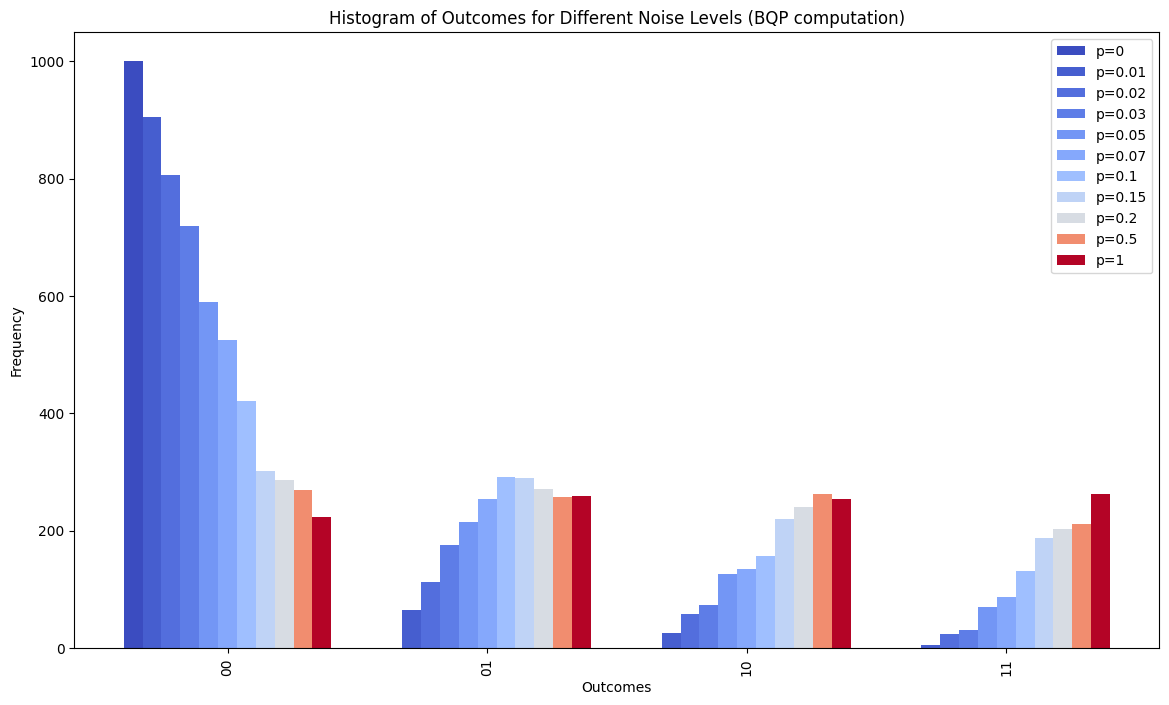

In [7]:
# Function to get color based on p value
def get_heatmap_color(p, colormap_name='coolwarm', vmin=0.1, vmax=1):
    colormap = cm.get_cmap(colormap_name)
    norm = LogNorm(vmin=vmin, vmax=vmax)  # Normalize p within [vmin, vmax]
    return colormap(norm(p))  # Get color for normalized p
# Plotting side-by-side bars with heatmap colors
x = np.arange(len(all_outcomes))  # X positions for outcomes
bar_width = 0.8 / len(p_values)  # Dynamic bar width based on the number of p values

plt.figure(figsize=(14, 8))

for idx, (p, histogram) in enumerate(all_histograms.items()):
    frequencies = [histogram.get(outcome, 0) for outcome in all_outcomes]
    color = get_heatmap_color(p+0.1)  # Get color based on p value
    plt.bar(x + idx * bar_width, frequencies, bar_width, color=color, label=f'p={p}')

plt.xlabel('Outcomes')
plt.ylabel('Frequency')
plt.title('Histogram of Outcomes for Different Noise Levels (BQP computation)')
plt.xticks(x + bar_width * (len(p_values) - 1) / 2, all_outcomes, rotation=90)
plt.legend()
plt.show()


### Plotting the results (plotly)

### Histogram for the computation rounds

In [12]:
import plotly.graph_objects as go
import matplotlib.cm as cm
from matplotlib.colors import LogNorm, to_hex

# Function to get color based on p value
def get_heatmap_color(p, colormap_name='coolwarm', vmin=0.1, vmax=1):
    colormap = cm.get_cmap(colormap_name)
    norm = LogNorm(vmin=vmin, vmax=vmax)  # Normalize p within [vmin, vmax]
    return to_hex(colormap(norm(p)))  # Convert to hex color for Plotly

# Initialize the figure
fig = go.Figure()

# Store the p values in a list to access them by index in buttons
p_values = list(all_histograms.keys())

# Add histograms for different 'p' values
for p, histogram in all_histograms.items():
    frequencies = [histogram.get(outcome, 0) for outcome in all_outcomes]
    
    # Get colors for each bar based on the current p value
    colors = [get_heatmap_color(p + 0.1) for _ in all_outcomes]
    
    fig.add_trace(
        go.Bar(
            x=all_outcomes,
            y=frequencies,
            name=f'p={p}',  # Legend label
            marker=dict(color=colors),  # Apply custom colors
            visible=(p == 0)  # Only p=0 is visible by default
        )
    )

fig.update_layout(
    title="Output bitstring occurrences, per noise level p",
    updatemenus=[
        {
            'type': 'buttons',
            'direction': 'right',
            'x': 0.5,  # Horizontal position of the buttons
            'y': 1.15,  # Vertical position above the chart
            'xanchor': 'center',  # Anchor buttons horizontally center
            'buttons': [
                {
                    'label': f'p= {key}',
                    'method': 'update',
                    'args': [{'visible': [i == idx for i in range(len(all_histograms))]}]
                }
                for idx, key in enumerate(all_histograms)
            ] + [
                {
                    'label': 'Show All',
                    'method': 'update',
                    'args': [{'visible': [True] * len(all_histograms)}]
                }
            ]
        }
    ]
)

# Set initial visibility (show only the first chart by default)
initial_visibility = [True] + [False] * (len(all_histograms) - 1)
fig.update_traces(visible=initial_visibility[0])

fig.show()


/var/folders/n5/hv7xz3zn675bw8ckw4q5ll3cmp3czq/T/ipykernel_18900/908283072.py:7: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



### Do we accept these outcomes ??? Plot the portion of failed/passed traps

In [9]:
# Create a list of pie chart traces
fig = go.Figure()
colors = ['#EF553B', '#a5ff33']  # Blue for 'Value', Red for 'Remaining'

for key, value in failed_traps_histograms.items():
    fig.add_trace(go.Pie(
        labels=['Failed traps', 'Passed traps'],
        values=[value, 1 - value],
        marker=dict(colors=colors),
        name=f'Key: {key}'
    ))

# Create fixed buttons for each pie chart
fig.update_layout(
    title="Proportion of failed/accepted traps, per noise level",
    updatemenus=[
        {
            'type': 'buttons',
            'direction': 'right',
            'x': 0.5,  # Horizontal position of the buttons
            'y': 1.15,  # Vertical position above the chart
            'xanchor': 'center',  # Anchor buttons horizontally center
            'buttons': [
                {
                    'label': f'p= {key}',
                    'method': 'update',
                    'args': [{'visible': [i == idx for i in range(len(failed_traps_histograms))]}]
                }
                for idx, key in enumerate(failed_traps_histograms)
            ]
        }
    ]
)

# Set initial visibility (show only the first chart by default)
initial_visibility = [True] + [False] * (len(failed_traps_histograms) - 1)
fig.update_traces(visible=initial_visibility[0])

fig.show()

In [18]:
import plotly.graph_objects as go
import matplotlib.cm as cm
from matplotlib.colors import LogNorm, to_hex
from plotly.subplots import make_subplots

# Function to get color based on p value
def get_heatmap_color(p, colormap_name='coolwarm', vmin=0.1, vmax=1):
    colormap = cm.get_cmap(colormap_name)
    norm = LogNorm(vmin=vmin, vmax=vmax)  # Normalize p within [vmin, vmax]
    return to_hex(colormap(norm(p)))  # Convert to hex color for Plotly

# Initialize the figure with subplots
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.7, 0.3],
    subplot_titles=("Output Bitstring Occurrences", "Failed/Passed Traps"),
    specs=[[{"type": "bar"}, {"type": "pie"}]]
)

# Store the p values in a list to access them by index in buttons
p_values = list(all_histograms.keys())

# Add bar charts and pie charts for different 'p' values
colors = ['#EF553B', '#a5ff33']  # Red for 'Failed traps', Green for 'Passed traps'

for idx, (p, histogram) in enumerate(all_histograms.items()):
    frequencies = [histogram.get(outcome, 0) for outcome in all_outcomes]
    
    # Get colors for each bar based on the current p value
    bar_colors = [get_heatmap_color(p + 0.1) for _ in all_outcomes]
    
    # Bar chart
    fig.add_trace(
        go.Bar(
            x=all_outcomes,
            y=frequencies,
            name=f'p={p}',  # Legend label
            marker=dict(color=bar_colors),  # Apply custom colors
            visible=(p == p_values[0])  # Only the first p is visible by default
        ),
        row=1, col=1
    )
    
    # Pie chart
    failed_value = failed_traps_histograms.get(p, 0)  # Fetch failed traps for current p
    fig.add_trace(
        go.Pie(
            labels=['Failed traps', 'Passed traps'],
            values=[failed_value, 1 - failed_value],
            marker=dict(colors=colors),
            name=f'p={p}',
            visible=(p == p_values[0])
        ),
        row=1, col=2
    )
    
# Update layout with buttons
fig.update_layout(
    title="Output bitstring occurrences and trap results per noise level p",
    updatemenus=[
        {
            'type': 'buttons',
            'direction': 'right',
            'x': 0.5,
            'y': 1.15,
            'xanchor': 'center',
            'buttons': [
                {
                    'label': f'p= {key}',
                    'method': 'update',
                    'args': [{'visible': [(i // 2 == idx) for i in range(2 * len(all_histograms))]}]
                }
                for idx, key in enumerate(all_histograms)
            ] + [
                {
                    'label': 'Show All',
                    'method': 'update',
                    'args': [{'visible': [True] * (2 * len(all_histograms))}]
                }
            ]
        }
    ]
)

fig.show()


/var/folders/n5/hv7xz3zn675bw8ckw4q5ll3cmp3czq/T/ipykernel_18900/4244744428.py:8: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



In [19]:
import plotly.graph_objects as go
import matplotlib.cm as cm
from matplotlib.colors import LogNorm, to_hex
from plotly.subplots import make_subplots

# Function to get color based on p value
def get_heatmap_color(p, colormap_name='coolwarm', vmin=0.1, vmax=1):
    colormap = cm.get_cmap(colormap_name)
    norm = LogNorm(vmin=vmin, vmax=vmax)  # Normalize p within [vmin, vmax]
    return to_hex(colormap(norm(p)))  # Convert to hex color for Plotly

# Number of rows and columns for the subplot grid
num_rows = len(all_histograms)  # Each p value gets its own row
num_cols = 2  # One column for bar chart, one for pie chart

# Create a subplot grid with multiple rows and columns
fig = make_subplots(
    rows=num_rows, cols=num_cols,
    column_widths=[0.7, 0.3],
    row_titles=[f'p={p}' for p in all_histograms.keys()],
    subplot_titles=["Output Bitstring Occurrences", "Failed/Passed Traps"] * len(all_histograms),
    vertical_spacing=0.05,
    specs=[[{"type": "bar"}, {"type": "pie"}] for _ in range(num_rows)]
)

# Add bar charts and pie charts for each p value
colors = ['#EF553B', '#a5ff33']  # Red for 'Failed traps', Green for 'Passed traps'

for idx, (p, histogram) in enumerate(all_histograms.items()):
    frequencies = [histogram.get(outcome, 0) for outcome in all_outcomes]
    
    # Get colors for each bar based on the current p value
    bar_colors = [get_heatmap_color(p + 0.1) for _ in all_outcomes]
    
    # Add bar chart to the first column
    fig.add_trace(
        go.Bar(
            x=all_outcomes,
            y=frequencies,
            name=f'Bitstrings (p={p})',
            marker=dict(color=bar_colors)
        ),
        row=idx + 1, col=1
    )
    
    # Add pie chart to the second column
    failed_value = failed_traps_histograms.get(p, 0)
    fig.add_trace(
        go.Pie(
            labels=['Failed traps', 'Passed traps'],
            values=[failed_value, 1 - failed_value],
            marker=dict(colors=colors),
            name=f'Traps (p={p})'
        ),
        row=idx + 1, col=2
    )

# Update layout for better spacing and appearance
fig.update_layout(
    title="Output Bitstring Occurrences and Trap Results per Noise Level (p)",
    height=400 * num_rows,  # Dynamic height based on the number of rows
    showlegend=False  # Disable legend for clarity
)

fig.show()


/var/folders/n5/hv7xz3zn675bw8ckw4q5ll3cmp3czq/T/ipykernel_18900/2457274934.py:8: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



In [14]:
print(all_histograms)
print(failed_traps_histograms)

{0: {'00': 1000}, 0.01: {'00': 905, '01': 65, '10': 25, '11': 5}, 0.02: {'00': 806, '01': 112, '10': 58, '11': 24}, 0.03: {'10': 74, '01': 175, '00': 720, '11': 31}, 0.05: {'00': 590, '10': 126, '01': 214, '11': 70}, 0.07: {'01': 254, '00': 525, '10': 134, '11': 87}, 0.1: {'00': 421, '10': 157, '01': 291, '11': 131}, 0.15: {'00': 302, '01': 290, '10': 220, '11': 188}, 0.2: {'10': 240, '00': 286, '11': 203, '01': 271}, 0.5: {'01': 257, '11': 211, '00': 270, '10': 262}, 1: {'01': 259, '10': 254, '11': 263, '00': 224}}
{0: 0.0, 0.01: 0.115, 0.02: 0.213, 0.03: 0.3, 0.05: 0.432, 0.07: 0.554, 0.1: 0.669, 0.15: 0.796, 0.2: 0.824, 0.5: 0.891, 1: 0.873}
